In [2]:
import pandas as pd
import numpy as np
import yfinance as yf


# Example: S&P 500 Index (^GSPC)
ticker = '^GSPC'  # You can change this
data = yf.download(ticker, start='2015-01-01', end='2025-01-01')

# Display the first rows
print(data.head())

C:\Users\MSI\AppData\Local\Temp\ipykernel_24992\2654124537.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2015-01-02  2058.199951  2072.360107  2046.040039  2058.899902  2708700000
2015-01-05  2020.579956  2054.439941  2017.339966  2054.439941  3799120000
2015-01-06  2002.609985  2030.250000  1992.439941  2022.150024  4460110000
2015-01-07  2025.900024  2029.609985  2005.550049  2005.550049  3805480000
2015-01-08  2062.139893  2064.080078  2030.609985  2030.609985  3934010000


In [ ]:
ticker = '^GSPC'
data = yf.download(ticker, start='2015-01-01', end='2025-01-01', progress=False)

# --- Step 2: State Representation ---

# 1. Define the lookback window size
# This determines how many past days of returns the agent sees.
WINDOW_SIZE = 10 # A common choice, you can experiment with this.

# 2. Calculate Daily Percentage Returns
# .pct_change() is the most robust way to calculate price differences (return_t = (Close_t - Close_{t-1}) / Close_{t-1})
data['Daily_Return'] = data['Close'].pct_change()

# Drop the first row which will have a NaN return
data.dropna(inplace=True)

# 3. Implement the get_state function
# This function extracts the state vector (past WINDOW_SIZE returns) at time 't'
def get_state(data, t, window_size):
    """
    Extracts the state vector for the agent at time t.
    The state consists of the daily returns from t - window_size to t - 1.

    :param data: DataFrame containing the 'Daily_Return' column.
    :param t: The current index/day of the simulation.
    :param window_size: The number of past days to include in the state.
    :return: A 1D numpy array (state vector).
    """
    # Start index for the lookback window
    start_index = t - window_size

    # Ensure we don't try to access data before the start of the returns series
    if start_index < 0:
        # If we are too early, pad with zeros or use the available data
        # For simplicity, we can use the available data and pad with zeros if needed.
        # However, for a proper RL start, we should only start trading after t >= window_size.
        # We will handle this by only using the data that is complete:
        return_vector = data['Daily_Return'].iloc[0:t].values # Use data from start up to t-1
        # Pad with zeros at the beginning to always ensure a vector of size 'window_size'
        padding = window_size - len(return_vector)
        if padding > 0:
             state = np.concatenate([np.zeros(padding), return_vector])
             return state
        return return_vector[-window_size:]

    # Extract the returns from the past window (from t-window_size up to t-1)
    # The agent uses *yesterday's* and older data to decide today's action.
    state = data['Daily_Return'].iloc[start_index:t].values

    # Reshape the state to be a 1-dimensional array, ready for the neural network
    return state.flatten()


# Example of the state vector for the first day the agent can trade (after the window size)
start_day_index = WINDOW_SIZE
example_state = get_state(data, start_day_index, WINDOW_SIZE)

print("\n--- Example State Vector ---")
print(f"Time Window Size: {WINDOW_SIZE} days")
print(f"State vector for day {data.index[start_day_index]}:")
print(example_state)
print(f"Shape of the state vector: {example_state.shape}")


--- Example State Vector ---
Time Window Size: 10 days
State vector for day 2015-01-20 00:00:00:
[-0.01827811 -0.00889347  0.01162984  0.01788828 -0.00840381 -0.00809369
 -0.00257856 -0.00581307 -0.00924788  0.0134242 ]
Shape of the state vector: (10,)


C:\Users\MSI\AppData\Local\Temp\ipykernel_24992\2867652432.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2025-01-01', progress=False)


In [8]:
# --- Step 3: Action Definition & Portfolio Management ---

# Initial Global/Simulation Variables (these will be updated at each time step)
INITIAL_BALANCE = 10000
COMMISSION_RATE = 0.001

# The portfolio state is tracked by these variables:
current_balance = INITIAL_BALANCE   # Cash available
stock_inventory = []                # List of purchase prices for held shares (used for FIFO/reward calc)
trade_log = []                      # List to record transactions (for Step 6 reporting)
stock_held = 0                      # Current number of shares held

# Action mappings for the DQN
ACTION_HOLD = 0
ACTION_BUY = 1
ACTION_SELL = 2

def execute_trade(action, current_price, balance, inventory, stock_held, trade_log, commission_rate):
    """
    Executes a trade action and updates the portfolio state.

    :returns: (new_balance, new_inventory, new_stock_held, new_trade_log, realized_profit)
    """
    
    # Initialize next state variables
    new_balance = balance
    new_inventory = list(inventory) # Create a copy to avoid modifying original state directly
    new_trade_log = list(trade_log)
    new_stock_held = stock_held
    realized_profit = 0 # This will be the reward (0 for Buy/Hold, profit/loss for Sell)

    # --- Buy Action (Action 1) ---
    if action == ACTION_BUY:
        # Check if the agent can afford to buy one share (including commission)
        cost = current_price * (1 + commission_rate)
        if balance >= cost:
            new_balance -= cost
            new_stock_held += 1
            new_inventory.append(current_price) # Record the purchase price
            
            commission = cost - current_price
            new_trade_log.append(('Buy', current_price, commission))
        # If not enough balance, the action implicitly becomes Hold (state doesn't change)
        
    # --- Sell Action (Action 2) ---
    elif action == ACTION_SELL:
        if stock_held > 0:
            # Sell one share
            sale_price_net = current_price * (1 - commission_rate)
            
            # Retrieve the oldest purchase price (FIFO)
            buy_price = new_inventory.pop(0) 
            
            # Calculate realized profit/loss (the reward for this step)
            realized_profit = sale_price_net - buy_price
            
            new_balance += sale_price_net
            new_stock_held -= 1
            
            commission = current_price - sale_price_net
            new_trade_log.append(('Sell', current_price, commission, realized_profit))
        # If no stock to sell, the action implicitly becomes Hold (state doesn't change)

    # --- Hold Action (Action 0) ---
    # If action is Hold (0), or implicitly became Hold (due to lack of funds/stock),
    # the new state variables will be the same as the old ones, and realized_profit remains 0.

    return new_balance, new_inventory, new_stock_held, new_trade_log, realized_profit


# Example of how the state will be updated in the main simulation loop:
# balance, inventory, stock_held, trade_log, reward = execute_trade(
#     action=ACTION_BUY, 
#     current_price=data['Close'].iloc[WINDOW_SIZE], 
#     balance=current_balance, 
#     inventory=stock_inventory, 
#     stock_held=stock_held, 
#     trade_log=trade_log, 
#     commission_rate=COMMISSION_RATE
# )

In [9]:
# --- Step 4: Reward Function ---

def get_reward(realized_profit):
    """
    Returns the immediate reward for the action taken at the current time step.
    
    :param realized_profit: The profit/loss from the execute_trade function.
    :return: The reward (float).
    """
    # The reward is simply the realized profit/loss from a sale, 
    # or 0 for Buy/Hold actions as per the lab requirements.
    return realized_profit

In [10]:
# --- 5a. Neural Network Architecture (Q-Function) ---

# Network Hyperparameters
INPUT_SIZE = 10 
HIDDEN_SIZE = 24
OUTPUT_SIZE = 3 # Actions: Hold, Buy, Sell

# Activation Function (Rectified Linear Unit)
def relu(x):
    """f(x) = max(0, x)"""
    return np.maximum(0, x)

# Derivative of ReLU (needed for backpropagation later)
def relu_derivative(x):
    """Derivative is 1 if x > 0, and 0 otherwise"""
    return (x > 0).astype(float)


# 1. Initialize Weights and Biases (The network parameters)
def initialize_network():
    """Initializes weights and biases with small random numbers (He/Kaiming initialization)"""
    
    # Weight 1 (Input: 10, Hidden: 24)
    # Using a scaling factor for better training stability (common in NN init)
    W1 = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * np.sqrt(2 / INPUT_SIZE)
    b1 = np.zeros((1, HIDDEN_SIZE))
    
    # Weight 2 (Hidden: 24, Output: 3)
    W2 = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE) * np.sqrt(2 / HIDDEN_SIZE)
    b2 = np.zeros((1, OUTPUT_SIZE))
    
    return W1, b1, W2, b2

# Initialize the Q-Network and Target Network weights (we need two sets for DQN)
W1, b1, W2, b2 = initialize_network() # Q-Network (Primary)
W1_target, b1_target, W2_target, b2_target = initialize_network() # Target Network (for stable learning)


# 2. Forward Pass Function (Prediction)
def forward_pass(state, W1, b1, W2, b2):
    """
    Computes the Q-values for a given state.
    state must be a 2D array (1, INPUT_SIZE)
    """
    
    # Layer 1: Linear Transformation and Activation
    # Z1 = State @ W1 + b1
    Z1 = np.dot(state, W1) + b1
    A1 = relu(Z1) # Activated Hidden Layer Output
    
    # Layer 2 (Output): Linear Transformation (Q-Values)
    # Z2 = A1 @ W2 + b2
    Q_values = np.dot(A1, W2) + b2 
    
    # Store intermediate values (Z1, A1) for backpropagation/training in Step 5c
    cache = (state, Z1, A1)
    
    return Q_values, cache

# Example Usage:
# state = np.random.rand(1, INPUT_SIZE) # Example state vector
# q_values, _ = forward_pass(state, W1, b1, W2, b2)
# print("\n--- Example Q-Value Prediction ---")
# print(f"Predicted Q-Values (Hold, Buy, Sell): {q_values}")
# print(f"Shape: {q_values.shape}")

In [11]:
# --- 5b. Experience Replay ---

# Hyperparameters
MEMORY_CAPACITY = 100000 
BATCH_SIZE = 32

# The Replay Memory (list of tuples: (state, action, reward, next_state, done))
memory = []

def remember(state, action, reward, next_state, done):
    """Adds a new experience to the memory."""
    # Ensure memory does not exceed capacity (optional, but good practice)
    if len(memory) >= MEMORY_CAPACITY:
        memory.pop(0) # Remove the oldest experience (FIFO)
    
    memory.append((state, action, reward, next_state, done))

def sample_experience(batch_size):
    """Randomly samples a batch of experiences from memory."""
    if len(memory) < batch_size:
        return None
        
    # Choose 'batch_size' random indices
    indices = np.random.choice(len(memory), batch_size, replace=False)
    
    # Extract and return the batch
    batch = [memory[i] for i in indices]
    
    # We will later process this batch to train the network.
    return batch

In [12]:
# Assuming forward_pass is defined and W1, b1, W2, b2 are initialized

def select_action(state, W1, b1, W2, b2, epsilon, OUTPUT_SIZE=3):
    """
    Chooses an action based on the epsilon-greedy strategy.
    
    :param state: The current state vector (1, INPUT_SIZE)
    :param epsilon: The probability of choosing a random action (exploration rate)
    :return: The action (0, 1, or 2)
    """
    if np.random.rand() <= epsilon:
        # Exploration: Choose a random action (Hold=0, Buy=1, Sell=2)
        return np.random.randint(OUTPUT_SIZE)
    else:
        # Exploitation: Predict Q-values and choose the best action
        # Note: We only need the Q_values, not the cache, for action selection
        Q_values, _ = forward_pass(state, W1, b1, W2, b2)
        
        # argmax returns the index of the maximum value (i.e., the best action)
        return np.argmax(Q_values[0])

In [13]:
# --- DQN Training Hyperparameters ---
GAMMA = 0.95            # Discount factor (for future rewards)
LEARNING_RATE = 0.001   # Alpha (step size for gradient descent)
TAU = 100               # Frequency to update the target network (e.g., copy every 100 steps)

# --- 5d. Training/Backpropagation Function ---

def train_q_network(W1, b1, W2, b2, W1_target, b1_target, W2_target, b2_target, 
                    memory, batch_size, gamma, learning_rate):
    """
    Performs one step of optimization using a mini-batch from experience replay.
    Updates the primary Q-Network weights (W1, b1, W2, b2).
    """
    
    # 1. Sample the batch
    batch = sample_experience(batch_size)
    if batch is None:
        return W1, b1, W2, b2 # Not enough data to train

    # Separate components into NumPy arrays for vectorized operations
    states = np.array([e[0][0] for e in batch]) # Shape (BATCH_SIZE, INPUT_SIZE)
    actions = np.array([e[1] for e in batch])   # Shape (BATCH_SIZE,)
    rewards = np.array([e[2] for e in batch])   # Shape (BATCH_SIZE,)
    next_states = np.array([e[3][0] for e in batch])
    dones = np.array([e[4] for e in batch])     # Boolean flags

    # 2. Calculate Target Q-Values (Y)
    
    # a. Get max Q-values for next_states using the TARGET network
    Q_next_values, _ = forward_pass(next_states, W1_target, b1_target, W2_target, b2_target)
    
    # max(Q_next_values) gives the maximum Q-value for each next state
    max_Q_next = np.max(Q_next_values, axis=1) 
    
    # b. Compute the target Y (R + gamma * max_Q_next)
    # If the episode is 'done' (final day), the future reward is 0.
    # The (1 - dones) converts True/False to 0/1 for multiplication.
    target_Y = rewards + gamma * max_Q_next * (1 - dones)
    target_Y = target_Y.reshape(-1, 1) # Reshape to (BATCH_SIZE, 1)

    # 3. Calculate Current Q-Values and Loss Gradient

    # a. Get Q-values for current states using the PRIMARY network
    Q_current_values, cache = forward_pass(states, W1, b1, W2, b2)
    state, Z1, A1 = cache
    
    # b. Compute the TD-Error (Temporal Difference Error)
    # The gradient of the Loss L = 1/2 * (target_Y - Q_current)^2 with respect to Q_current is:
    # dL/dQ_current = Q_current - target_Y
    
    # Create the error matrix (dL/dQ), which is zero everywhere except for the taken action
    error_matrix = Q_current_values - target_Y # Error for the *selected* action
    
    # We only update the Q-value corresponding to the action A taken at state S.
    # Create a mask to zero out the gradients for the actions not taken.
    mask = np.zeros_like(Q_current_values)
    mask[np.arange(batch_size), actions] = 1 # Set 1 at the (batch_index, action_index)
    
    # The final derivative of Loss w.r.t Q-values is the TD-Error applied only to the taken action
    dQ_grad = error_matrix * mask # Shape (BATCH_SIZE, OUTPUT_SIZE)
    
    # 4. Backpropagation (Chain Rule)

    # --- Backprop Layer 2 (Output Layer: A1 -> Q) ---
    # dL/dW2 = A1^T @ dL/dQ
    dW2 = np.dot(A1.T, dQ_grad)
    # dL/db2 = Sum(dL/dQ) along the batch dimension
    db2 = np.sum(dQ_grad, axis=0, keepdims=True)
    
    # Propagate gradient back to Hidden Layer Output A1
    # dL/dA1 = dL/dQ @ W2^T
    dA1_grad = np.dot(dQ_grad, W2.T) # Shape (BATCH_SIZE, HIDDEN_SIZE)

    # --- Backprop Layer 1 (Hidden Layer: Z1 -> A1 -> Z1 -> State) ---
    # Apply the ReLU derivative: dL/dZ1 = dL/dA1 * d(ReLU)/dZ1
    dZ1_grad = dA1_grad * relu_derivative(Z1) # Shape (BATCH_SIZE, HIDDEN_SIZE)
    
    # dL/dW1 = State^T @ dL/dZ1
    dW1 = np.dot(state.T, dZ1_grad)
    # dL/db1 = Sum(dL/dZ1) along the batch dimension
    db1 = np.sum(dZ1_grad, axis=0, keepdims=True)

    # 5. Update Weights (Gradient Descent)
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    # Return the updated primary weights
    return W1, b1, W2, b2


# --- 5e. Target Network Update ---

def update_target_network(W1, b1, W2, b2, W1_target, b1_target, W2_target, b2_target):
    """
    Copies the primary Q-Network weights to the target Q-Network.
    """
    W1_target[:] = W1[:]
    b1_target[:] = b1[:]
    W2_target[:] = W2[:]
    b2_target[:] = b2[:]
    print(f"Target network updated.")
    
    return W1_target, b1_target, W2_target, b2_target

In [15]:
# --- 6a. Helper Function: Portfolio Value ---

def get_portfolio_value(balance, stock_held, current_price):
    """
    Calculates the total value of the agent's portfolio.
    Value = Cash Balance + (Stock Quantity * Current Price)
    """
    return balance + (stock_held * current_price)


# --- 6b. Evaluation Metrics ---

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.0001):
    """
    Calculates the annualized Sharpe Ratio.
    
    :param daily_returns: A 1D NumPy array of daily percentage returns of the portfolio.
    :param risk_free_rate: Annualized risk-free rate (e.g., 1% annually, or ~0.0001 daily for 252 trading days)
    :return: The Sharpe Ratio.
    """
    # Annualization factor for daily data (assuming 252 trading days/year)
    ANNUALIZATION_FACTOR = np.sqrt(252)
    
    # 1. Calculate Excess Returns (Daily Return - Daily Risk-Free Rate)
    # Convert annualized risk-free rate to daily rate
    daily_risk_free_rate = (1 + risk_free_rate)**(1/252) - 1
    excess_returns = daily_returns - daily_risk_free_rate
    
    # 2. Calculate Average Excess Return and Standard Deviation
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns)
    
    if std_excess_return == 0:
        return 0
        
    # 3. Calculate Annualized Sharpe Ratio
    sharpe_ratio = ANNUALIZATION_FACTOR * (mean_excess_return / std_excess_return)
    return sharpe_ratio




In [16]:
# --- 6c. Main Simulation and Training Loop (Corrected) ---

# Epsilon Decay Hyperparameters (kept the same)
EPSILON_START = 1.0     
EPSILON_END = 0.01      
EPSILON_DECAY_RATE = 0.9995 

# Reset/Load Global State (from Step 3)
current_balance = INITIAL_BALANCE
stock_inventory = []
trade_log = []
stock_held = 0

# Variables for tracking performance (for Step 6)
total_rewards = 0
portfolio_values = []
actions_taken = []
epsilon = EPSILON_START
step_count = 0

# --- Start Simulation ---
print("\n--- Starting Deep Q-Learning Simulation ---")
print(f"Total days to simulate: {len(data) - WINDOW_SIZE}")

# The simulation starts after the initial WINDOW_SIZE days are used to form the first state
for t in range(WINDOW_SIZE, len(data)):
    # 1. Get Current State and Price
    current_state_flat = get_state(data, t, WINDOW_SIZE)
    # Reshape for the forward pass (1, 10)
    current_state = current_state_flat.reshape(1, INPUT_SIZE) 
    
    # FIX: Explicitly extract the scalar value using .item()
    current_price = data['Close'].iloc[t].item() 
    
    # 2. Select Action using Epsilon-Greedy
    action = select_action(current_state, W1, b1, W2, b2, epsilon)

    # 3. Execute Trade (Action -> New State & Reward)
    new_balance, new_inventory, new_stock_held, new_trade_log, realized_profit = execute_trade(
        action=action, 
        current_price=current_price, 
        balance=current_balance, 
        inventory=stock_inventory, 
        stock_held=stock_held, 
        trade_log=trade_log, 
        commission_rate=COMMISSION_RATE
    )
    
    # 4. Define Next State and Done Flag
    next_state_t = t + 1
    if next_state_t < len(data):
        next_state_flat = get_state(data, next_state_t, WINDOW_SIZE)
        next_state = next_state_flat.reshape(1, INPUT_SIZE)
        done = False
    else:
        next_state = np.zeros((1, INPUT_SIZE))
        done = True
    
    # 5. Get Reward
    reward = get_reward(realized_profit)
    total_rewards += reward 

    # 6. Remember Experience (S, A, R, S', Done)
    remember(current_state, action, reward, next_state, done)

    # 7. Update Portfolio State for the next day
    current_balance = new_balance
    stock_inventory = new_inventory
    stock_held = new_stock_held
    trade_log = new_trade_log
    
    # 8. Train the Q-Network
    if len(memory) > BATCH_SIZE:
        W1, b1, W2, b2 = train_q_network(
            W1, b1, W2, b2, W1_target, b1_target, W2_target, b2_target, 
            memory, BATCH_SIZE, GAMMA, LEARNING_RATE
        )

    # 9. Update Target Network periodically
    if step_count % TAU == 0:
        W1_target, b1_target, W2_target, b2_target = update_target_network(
            W1, b1, W2, b2, W1_target, b1_target, W2_target, b2_target
        )
    
    # 10. Epsilon Decay
    if epsilon > EPSILON_END:
        epsilon *= EPSILON_DECAY_RATE
    
    step_count += 1
    
    # 11. Track Performance
    current_portfolio_value = get_portfolio_value(current_balance, stock_held, current_price)
    portfolio_values.append(current_portfolio_value)
    actions_taken.append(action)
    
    if t % 250 == 0 and t > WINDOW_SIZE:
        print(f"Day {t}/{len(data)} | Epsilon: {epsilon:.4f} | Value: ${current_portfolio_value:,.2f}")


# --- Final Evaluation ---

# 1. Total Profit
final_value = portfolio_values[-1] if portfolio_values else INITIAL_BALANCE
total_profit = final_value - INITIAL_BALANCE

# 2. Daily Returns for Sharpe Ratio
portfolio_np = np.array(portfolio_values)
daily_returns = np.diff(portfolio_np) / portfolio_np[:-1]

# 3. Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(daily_returns)

print("\n--- Simulation Results ---")
print(f"Total Trading Days: {step_count}")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Profit/Loss: ${total_profit:,.2f}")
print(f"Cumulative Reward (Realized Profit): ${total_rewards:,.2f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")

print("\n--- Data for Visualization ---")
print(f"Portfolio Values collected: {len(portfolio_values)}")
print(f"Actions collected: {len(actions_taken)}")


--- Starting Deep Q-Learning Simulation ---
Total days to simulate: 2505
Target network updated.
Target network updated.
Target network updated.
Day 250/2515 | Epsilon: 0.8865 | Value: $9,562.14
Target network updated.
Target network updated.
Day 500/2515 | Epsilon: 0.7823 | Value: $10,533.89
Target network updated.
Target network updated.
Target network updated.
Day 750/2515 | Epsilon: 0.6903 | Value: $10,764.46
Target network updated.
Target network updated.
Day 1000/2515 | Epsilon: 0.6092 | Value: $10,007.80
Target network updated.
Target network updated.
Target network updated.
Day 1250/2515 | Epsilon: 0.5376 | Value: $10,147.54
Target network updated.
Target network updated.
Day 1500/2515 | Epsilon: 0.4744 | Value: $10,486.36
Target network updated.
Target network updated.
Target network updated.
Day 1750/2515 | Epsilon: 0.4187 | Value: $10,985.37
Target network updated.
Target network updated.
Day 2000/2515 | Epsilon: 0.3694 | Value: $10,323.24
Target network updated.
Target net

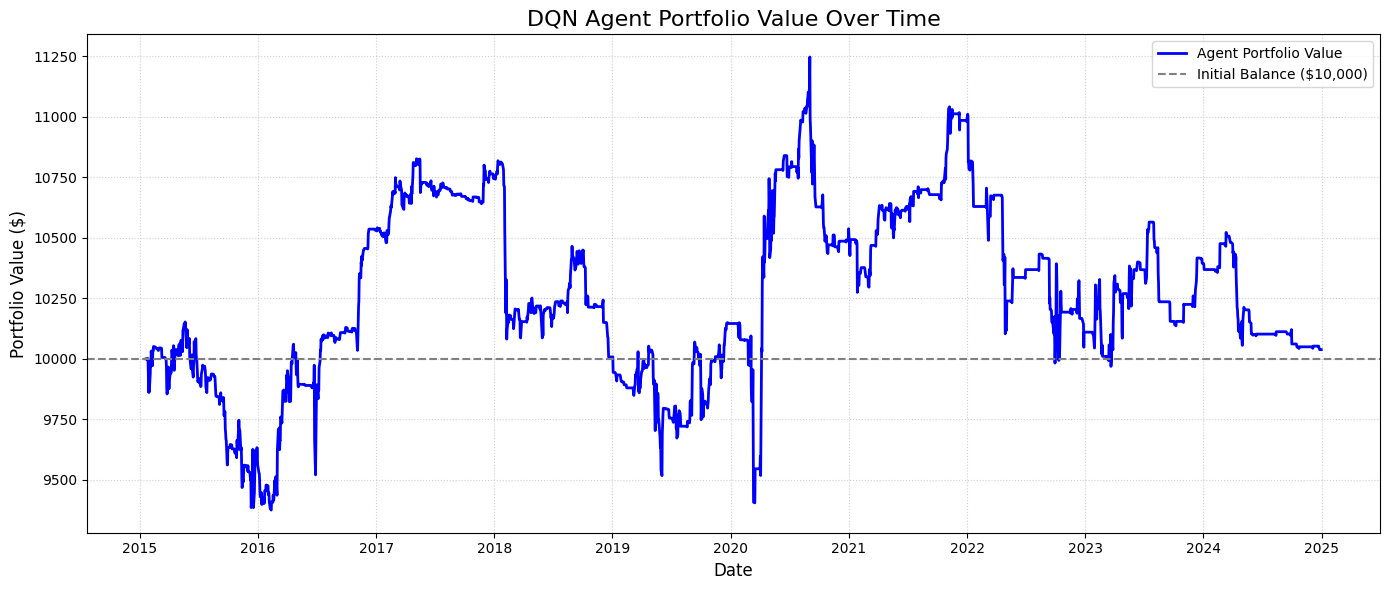

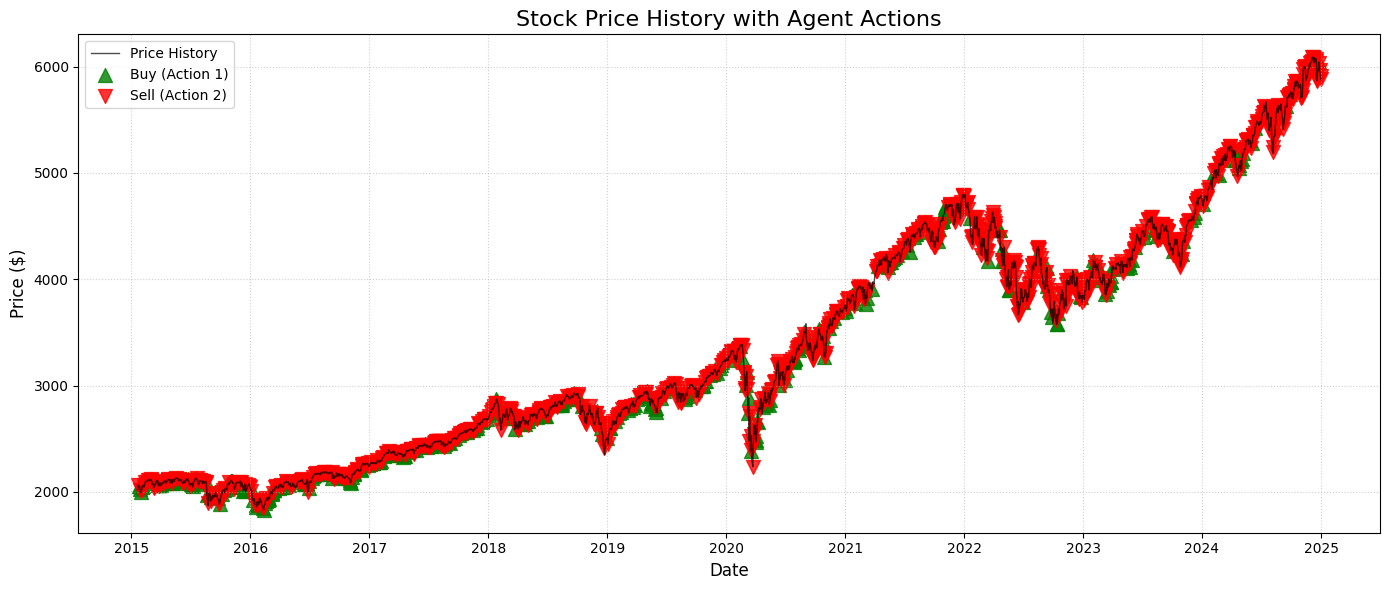

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Prepare Data for Plotting ---

# We use np.array(list).flatten() to ensure all data is definitively a 1D vector (N,)
# The .iloc[WINDOW_SIZE:].values is the most likely culprit for the error.
dates = data.index[WINDOW_SIZE:] # This is a Pandas Index, which is 1D

plot_df = pd.DataFrame({
    'Portfolio Value': np.array(portfolio_values).flatten(),
    'Close Price': data['Close'].iloc[WINDOW_SIZE:].values.flatten(), # Key Fix: .flatten() added here
    'Action': np.array(actions_taken).flatten()
})
# Assign the dates index after creation to avoid potential alignment issues
plot_df.index = dates

# Define action indices for clarity in plotting
ACTION_BUY = 1 # Redefine constants just in case they were lost
ACTION_SELL = 2

buy_indices = plot_df[plot_df['Action'] == ACTION_BUY].index
sell_indices = plot_df[plot_df['Action'] == ACTION_SELL].index

# --- 2. Plot A: Portfolio Value Over Time ---

plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['Portfolio Value'], label='Agent Portfolio Value', color='blue', linewidth=2)
plt.axhline(y=INITIAL_BALANCE, color='gray', linestyle='--', label=f'Initial Balance (${INITIAL_BALANCE:,.0f})')
plt.title('DQN Agent Portfolio Value Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('portfolio_value_plot.png')
plt.show()

# --- 3. Plot B: Stock Price with Agent Actions ---

buy_prices = plot_df.loc[buy_indices, 'Close Price']
sell_prices = plot_df.loc[sell_indices, 'Close Price']

plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['Close Price'], label='Price History', color='black', alpha=0.7, linewidth=1)

plt.scatter(buy_indices, buy_prices, marker='^', color='green', s=100, label='Buy (Action 1)', alpha=0.8)
plt.scatter(sell_indices, sell_prices, marker='v', color='red', s=100, label='Sell (Action 2)', alpha=0.8)

plt.title('Stock Price History with Agent Actions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('agent_actions_plot.png')
plt.show()